# Train LSTM model

to predict next day mean temp based on past 7 seven days mean temp

Source: https://odp.met.hu/tree.html

In [11]:
import pandas as pd
from datetime import date

In [12]:
def convert_date(raw: int):
    year = str(raw)[:4]
    month = str(raw)[4:6]
    day = str(raw)[6:8]
    return date(int(year), int(month), int(day))

def load_met_csv(path: str, temp_col: str, time_col: str) -> pd.DataFrame:
    df = pd.read_csv(path, sep=';')
    df.columns=[time_col, temp_col, "EOR"]
    df = df.drop(columns=["EOR"])
    df["date"] = df["date"].apply(convert_date)
    return df

In [13]:
DATE_COL = "date"
df_min = load_met_csv("bud_min.csv", "min", DATE_COL)
df_max = load_met_csv("bud_max.csv", "max", DATE_COL)
df_mean = load_met_csv("bud_mean.csv", "mean", DATE_COL)
df = df_min.merge(df_max, on=[DATE_COL]).merge(df_mean, on=[DATE_COL])
df

,date,min,max,mean
0,1901-01-01,-9.5,-0.3,-5.7
1,1901-01-02,-11.6,-6.5,-9.3
2,1901-01-03,-11.1,-6.5,-9.1
3,1901-01-04,-12.7,-9.7,-11.0
4,1901-01-05,-15.8,-8.9,-11.1
...,...,...,...,...
44920,2023-12-27,5.1,11.2,8.5
44921,2023-12-28,2.0,9.6,5.3
44922,2023-12-29,1.1,9.1,4.5
44923,2023-12-30,0.5,12.8,5.1


In [14]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

In [15]:
# Extract the 'mean' column and normalize it
mean_values = df['mean'].values.reshape(-1, 1)

# Create sequences of 7 days and the next day's target
sequence_length = 7
X, y = [], []
for i in range(len(mean_values) - sequence_length):
    X.append(mean_values[i:i + sequence_length])
    y.append(mean_values[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Split into training and validation sets
slice_idx = int(0.8*len(X))
X_train, X_val, y_train, y_val = X[:slice_idx], X[slice_idx:], y[:slice_idx], y[slice_idx:]

In [18]:
# Step 2: Define the LSTM model
model = Sequential([
    Input((7, 1)),
    LSTM(16, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 16)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,169 (4.57 KB)

 Trainable params: 1,169 (4.57 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Step 3: Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)

Epoch 1/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 10.4843 - val_loss: 4.5737
Epoch 2/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.7626 - val_loss: 4.7155
Epoch 3/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.7368 - val_loss: 4.5760
Epoch 4/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.8367 - val_loss: 4.6091
Epoch 5/5
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.7825 - val_loss: 4.4769


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


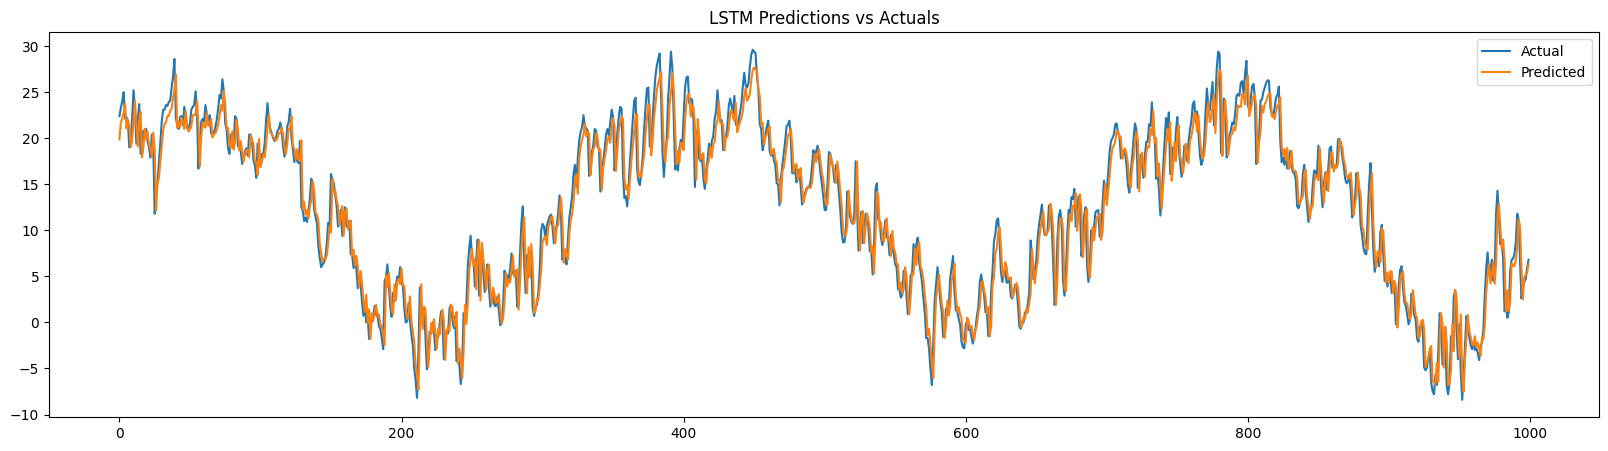

In [20]:
# Step 4: Evaluate and visualize predictions
import matplotlib.pyplot as plt

# Predict on validation set
y_pred = model.predict(X_val)
y_pred_rescaled = y_pred
y_val_rescaled = y_val

# Plot predictions vs actuals
plt.figure(figsize=(20, 5))
plt.plot(y_val_rescaled[:1000], label="Actual")
plt.plot(y_pred_rescaled[:1000], label="Predicted")
plt.legend()
plt.title("LSTM Predictions vs Actuals")
plt.show()

Validation Error Statistics:
Average Error: 1.66
Maximum Error: 9.78
Minimum Error: 0.00


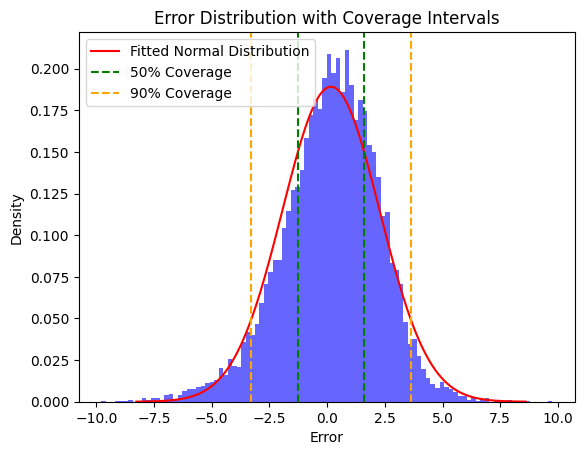

In [24]:
from scipy.stats import norm

# Calculate the errors for each prediction
errors = y_val_rescaled - y_pred_rescaled

# Calculate statistics
average_error = np.mean(np.abs(errors))
max_error = np.max(np.abs(errors))
min_error = np.min(np.abs(errors))

# Print error statistics
print(f"Validation Error Statistics:")
print(f"Average Error: {average_error:.2f}")
print(f"Maximum Error: {max_error:.2f}")
print(f"Minimum Error: {min_error:.2f}")

# Fit a normal distribution to the errors
mean_error = np.mean(errors)
std_error = np.std(errors)

# Create a range of values for the normal distribution
x = np.linspace(mean_error - 4 * std_error, mean_error + 4 * std_error, 500)
pdf = norm.pdf(x, mean_error, std_error)

# Calculate the 50% and 90% coverage limits
p50_lower, p50_upper = norm.interval(0.50, loc=mean_error, scale=std_error)
p90_lower, p90_upper = norm.interval(0.90, loc=mean_error, scale=std_error)

# Plot the histogram and the normal distribution
plt.hist(errors, bins=100, density=True, alpha=0.6, color='blue')
plt.plot(x, pdf, 'r-', label='Fitted Normal Distribution')

# Add vertical lines for the 50% and 90% intervals
plt.axvline(p50_lower, color='green', linestyle='--', label='50% Coverage')
plt.axvline(p50_upper, color='green', linestyle='--')
plt.axvline(p90_lower, color='orange', linestyle='--', label='90% Coverage')
plt.axvline(p90_upper, color='orange', linestyle='--')

# Add labels and legend
plt.title("Error Distribution with Coverage Intervals")
plt.xlabel("Error")
plt.ylabel("Density")
plt.legend()
plt.show()

In [26]:
# Save the model
model.save('lstm_model.keras')

In [28]:
from tensorflow.keras.models import load_model

# Reload the model
reloaded_model = load_model('lstm_model.keras')

In [29]:
# Use the reloaded model to make predictions
y_pred = reloaded_model.predict(X_val)

# Print some of the predictions
print("Sample Predictions:")
for i in range(5):  # Print the first 5 predictions
    print(f"Actual: {y_val_rescaled[i][0]:.2f}, Predicted: {y_pred[i][0]:.2f}")

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Sample Predictions:
Actual: 22.40, Predicted: 19.87
Actual: 23.30, Predicted: 21.65
Actual: 24.00, Predicted: 22.14
Actual: 25.00, Predicted: 22.79
Actual: 22.10, Predicted: 23.74
